# Graded Assignment 7.1: Improved Digit Generation with VAEs

- Done by: A Alkaff Ahamed
- Grade: Pending
- 27 May 2025


## Learning Outcome Addressed
- Learn to implement and leverage Generative AI methods, including diffusion models and multimodal systems, to develop creative and innovative AI solutions.

Time to test your skills on the topics covered in this week. We recommend you try going through the [Python documentation](https://www.python.org/about/help/). if you have any issues. You may find some useful reference links in the Week 7: Video Transcripts and Additional Readings Page. You can also discuss your experience with your peers using the Week 7: Q&A Discussion Board.


## Assignment Instructions:

In this assignment, you will experiment further with a VAE for generating handwritten digits. As a starting point, you may use the Jupyter Notebook provided by Prof. Mario during his demonstration here - VAE_MNIST_Notebook.ipynb


### Tasks:

#### Task 1: Visualise the latent space

- Visualise the 2D latent space used by this model as a scatterplot
- Use `alpha=0.7` and `s=3` for the scatterplot
- Display the scatterplot for each digit in a different colour

#### Task 2: Change epochs

- Run the code with `5`, `15` and `30` epochs
- Take screenshots of the latent space and generated digits for each

#### Task 3: Analyse the output

- Briefly describe how the latent space has changed with the number of epochs (Approx. 100 words)
- Briefly describe how the quality of generated digits has changed with the number of epochs (Approx. 100 words)
- OPTIONAL - What would happen if you try 50 or 100 epochs? Does the model get better or worse?


**Estimated time:** 60-90 minutes

**Additional Tips:**

- You can refer to this website for help on visualising the 2D latent space - [https://www.tensorflow.org/tutorials/generative/cvae](https://www.tensorflow.org/tutorials/generative/cvae)

**Submission Instructions:**

- Select the Start Assignment button at the top right of this page.
- Upload your answers in the form of a Word or PDF file.
- Upload the Python file (.ipynb) you used to complete this assignment.
- Select the Submit Assignment button to submit your responses.

*This is a graded and counts towards programme completion. You may attempt this assignment only once.*


## Import Libraries and Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Optional: Reproducibility
import random
random.seed(44)
np.random.seed(44)
tf.random.set_seed(44)

In [2]:
from tensorflow.python.client import device_lib

# Display all logical devices
for device in device_lib.list_local_devices():
    if device.device_type == 'GPU':
        print(f"✅ GPU Detected: {device.name} | {device.physical_device_desc}")

✅ GPU Detected: /device:GPU:0 | device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Setup Functions and Classes

In [3]:
# Load and Prepare Data
# ---------------------

(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))

num_classes = 10
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes)

print(x_train.shape)
print(y_train.shape)
print(y_train_ohe.shape)

# Prepare for the CVAE Model
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_ohe))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


(60000, 28, 28, 1)
(60000,)
(60000, 10)


In [4]:
# Hyperarameters
# --------------

input_shape = (28, 28, 1)
latent_dim = 2
intermediate_dim = 512
epochs = 5


In [5]:
# Sampling Layer
# --------------

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



In [6]:
# Encoder
# -------

# Inputs (Image)
image_input = Input(shape=input_shape, name="image_input")  # (28, 28, 1)
label_input = Input(shape=(num_classes,), name="label_input")  # (10,)

# Flatten image and concatenate with label
x_img = Flatten()(image_input)  # shape: (None, 784)
x = Concatenate()([x_img, label_input])  # shape: (None, 784 + 10 = 794)

# Dense layers
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

# Define encoder model with 2 inputs (image + label)
encoder = Model([image_input, label_input], [z_mean, z_log_var, z], name='encoder')


In [7]:
# Decoder
# -------

# Inputs (Latent)
latent_input = Input(shape=(latent_dim,), name="latent_input")        # shape: (None, 2)
label_input = Input(shape=(num_classes,), name="label_input")         # shape: (None, 10)

# Concatenate latent vector with label
x = Concatenate()([latent_input, label_input])                         # shape: (None, 2 + 10 = 12)

# Dense Layers
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoder_outputs = Reshape((28, 28, 1))(x)

# Define conditional decoder
decoder = Model([latent_input, label_input], decoder_outputs, name='decoder')


In [8]:
# Conditional VAE (CVAE) Class
# ----------------------------

class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        x, y = data  # x: images, y: one-hot labels

        with tf.GradientTape() as tape:
            # Encode (x, y) → z
            z_mean, z_log_var, z = self.encoder([x, y])

            # Decode (z, y) → reconstruction
            reconstruction = self.decoder([z, y])

            # Flatten input and reconstruction for BCE
            flat_x = tf.reshape(x, (-1, 784))
            flat_reconstruction = tf.reshape(reconstruction, (-1, 784))

            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(flat_x, flat_reconstruction)
            ) * 784

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Log losses
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        x, y = inputs  # Inference requires both image and label
        _, _, z = self.encoder([x, y])
        return self.decoder([z, y])


In [9]:
# Generate Digits and Plots
# -------------------------

def generate_digits(decoder, digit, n=10):
    """
    Generate n images of a specific digit using the CVAE decoder.
    
    Args:
        decoder: the decoder model
        digit: integer 0-9 specifying the digit to generate
        n: number of images to generate

    Returns:
        numpy array of shape (n, 28, 28, 1)
    """
    z_sample = np.random.normal(size=(n, latent_dim))
    
    # One-hot encode the digit
    y = tf.keras.utils.to_categorical([digit] * n, num_classes=10)

    # Concatenate z and y before decoding
    x_decoded = decoder.predict([z_sample, y])
    return x_decoded

def plot_digits(images, title, filename):
    """
    Plots one row of digits from 0 to 9.

    Args:
        images: list or np.ndarray of shape (10, 28, 28[, 1])
        title: string to display above the image grid
        filename: if provided, saves the figure to this path
    """
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        img = images[i].squeeze()  # Removes channel dimension if present
        plt.imshow(img, cmap='gray')
        plt.title(str(i), fontsize=10)
        plt.axis('off')
    
    plt.suptitle(title, y=1.15, fontsize=14)
    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        print(f"Saved to {filename}")
    
    plt.show()

def plot_latent(encoder, x_test, y_test, title, filename):
    """
    Plots the 2D latent space encoded by the encoder model.

    Args:
        encoder: Trained encoder model returning z_mean as part of its output
        x_test: Images to encode (shape: N x 28 x 28 x 1)
        y_test: Corresponding digit labels (shape: N,)
        title: Plot title
        filename: If provided, saves plot to the specified file
    """
    # Do one-hot encoding first
    y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    
    # Extract only z_mean from encoder
    z_mean, _, _ = encoder.predict((x_test, y_test_ohe), batch_size=batch_size)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', s=3, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label="Digit")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(title)

    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved to {filename}")
    
    plt.show()



## 📌 Task 1 and 2: Train for 5, 15 and 30 epochs and visualise

**Task 1: Visualise the latent space**

- Visualise the 2D latent space used by this model as a scatterplot
- Use `alpha=0.7` and `s=3` for the scatterplot
- Display the scatterplot for each digit in a different colour

**Task 2: Change epochs**

- Run the code with `5`, `15` and `30` epochs
- Take screenshots of the latent space and generated digits for each


## 🔁 5 Epoch

In [10]:
# Create CVAE
# -----------

print("Creating CVAE model...")
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


Creating CVAE model...


In [11]:
# Hyperarameters
# --------------

epochs = 5
init_epoch = 0


In [12]:
# !!! TRAIN MODEL - 5 Epoch!!!
# ----------------------------

cvae.fit(train_dataset,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True)


Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 371.3300 - reconstruction_loss: 259.4345 - kl_loss: 24.4830
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 203.4848 - reconstruction_loss: 186.8440 - kl_loss: 10.2546
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 182.1823 - reconstruction_loss: 172.1129 - kl_loss: 6.7381
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 170.6860 - reconstruction_loss: 163.2124 - kl_loss: 5.4201
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 162.8375 - reconstruction_loss: 156.3606 - kl_loss: 4.8079


1/1 [==============================] - 0s 16ms/step
Saved to task_1a_5epoch_digits.png


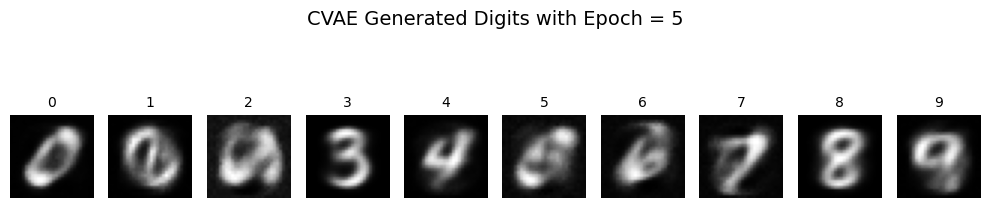

In [13]:
digits = [generate_digits(decoder, digit=i, n=1)[0] for i in range(10)]
plot_digits(digits, title="CVAE Generated Digits with Epoch = 5", filename="task_1a_5epoch_digits.png")

79/79 [==============================] - 0s 1ms/step
Saved to task_1b_5epoch_latent_space.png


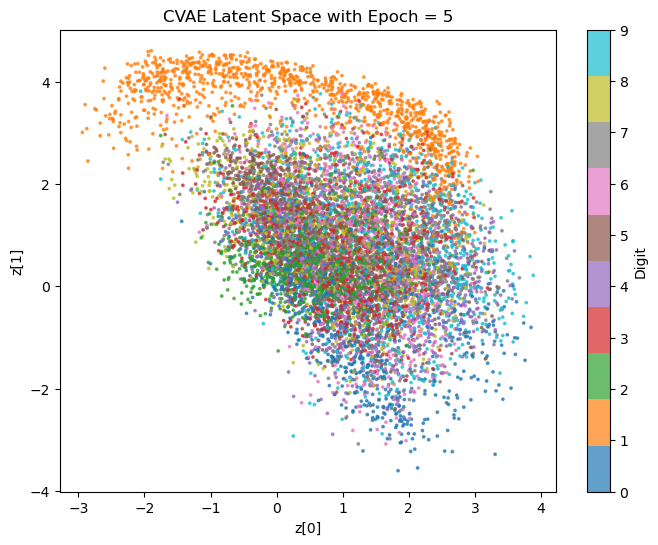

In [14]:
# Assuming you already split or use a subset of test data
plot_latent(encoder, x_train[:10000], y_train[:10000], title="CVAE Latent Space with Epoch = 5", filename="task_1b_5epoch_latent_space.png")


## 🔁 15 Epoch

In [15]:
# Hyperarameters
# --------------

epochs = 15
init_epoch = 5


In [16]:
# !!! TRAIN MODEL - 15 Epoch!!!
# -----------------------------

cvae.fit(train_dataset,
        epochs=epochs,
        initial_epoch=init_epoch,
        batch_size=batch_size,
        shuffle=True)


Epoch 6/15
469/469 [==============================] - 3s 6ms/step - loss: 156.1850 - reconstruction_loss: 150.5388 - kl_loss: 4.5391
Epoch 7/15
469/469 [==============================] - 3s 6ms/step - loss: 151.8373 - reconstruction_loss: 146.8949 - kl_loss: 4.3904
Epoch 8/15
469/469 [==============================] - 3s 6ms/step - loss: 149.0738 - reconstruction_loss: 144.5755 - kl_loss: 4.2907
Epoch 9/15
469/469 [==============================] - 3s 6ms/step - loss: 147.1867 - reconstruction_loss: 142.8854 - kl_loss: 4.2524
Epoch 10/15
469/469 [==============================] - 3s 6ms/step - loss: 145.7705 - reconstruction_loss: 141.5298 - kl_loss: 4.2396
Epoch 11/15
469/469 [==============================] - 3s 6ms/step - loss: 144.5946 - reconstruction_loss: 140.4004 - kl_loss: 4.2463
Epoch 12/15
469/469 [==============================] - 3s 6ms/step - loss: 143.5636 - reconstruction_loss: 139.4576 - kl_loss: 4.2521
Epoch 13/15
469/469 [==============================] - 3s 6ms/step

1/1 [==============================] - 0s 9ms/step
Saved to task_1c_15epoch_digits.png


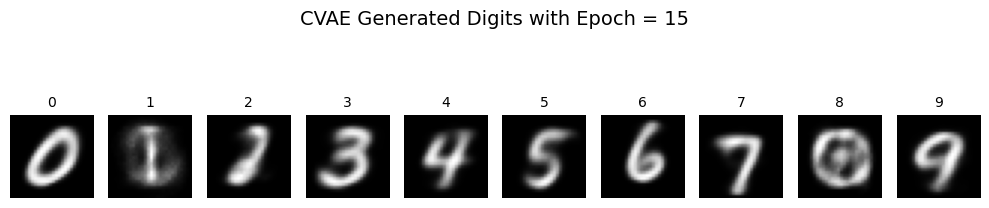

In [17]:
digits = [generate_digits(decoder, digit=i, n=1)[0] for i in range(10)]
plot_digits(digits, title="CVAE Generated Digits with Epoch = 15", filename="task_1c_15epoch_digits.png")

79/79 [==============================] - 0s 1ms/step
Saved to task_1d_15epoch_latent_space.png


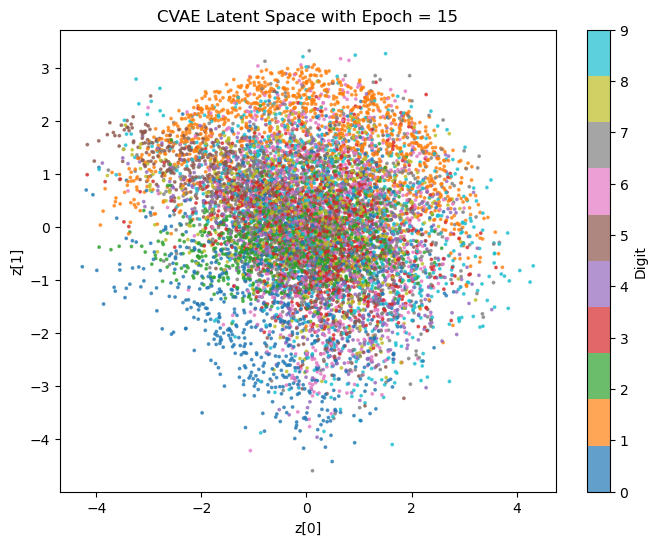

In [18]:
# Assuming you already split or use a subset of test data
plot_latent(encoder, x_train[:10000], y_train[:10000], title="CVAE Latent Space with Epoch = 15", filename="task_1d_15epoch_latent_space.png")


## 🔁 30 Epoch

In [19]:
# Hyperarameters
# --------------

epochs = 30
init_epoch = 15


In [20]:
# !!! TRAIN MODEL - 30 Epoch!!!
# -----------------------------

cvae.fit(train_dataset,
        epochs=epochs,
        initial_epoch=init_epoch,
        batch_size=batch_size,
        shuffle=True)


Epoch 16/30
469/469 [==============================] - 3s 6ms/step - loss: 140.7879 - reconstruction_loss: 136.7755 - kl_loss: 4.2563
Epoch 17/30
469/469 [==============================] - 3s 6ms/step - loss: 140.3455 - reconstruction_loss: 136.2782 - kl_loss: 4.2576
Epoch 18/30
469/469 [==============================] - 3s 6ms/step - loss: 139.9043 - reconstruction_loss: 135.8172 - kl_loss: 4.2670
Epoch 19/30
469/469 [==============================] - 3s 6ms/step - loss: 139.3899 - reconstruction_loss: 135.4063 - kl_loss: 4.2772
Epoch 20/30
469/469 [==============================] - 3s 6ms/step - loss: 138.9522 - reconstruction_loss: 135.0228 - kl_loss: 4.2698
Epoch 21/30
469/469 [==============================] - 3s 6ms/step - loss: 138.6559 - reconstruction_loss: 134.6425 - kl_loss: 4.2710
Epoch 22/30
469/469 [==============================] - 3s 6ms/step - loss: 138.3350 - reconstruction_loss: 134.3138 - kl_loss: 4.2825
Epoch 23/30
469/469 [==============================] - 3s 6ms/

1/1 [==============================] - 0s 14ms/step
Saved to task_1e_30epoch_digits.png


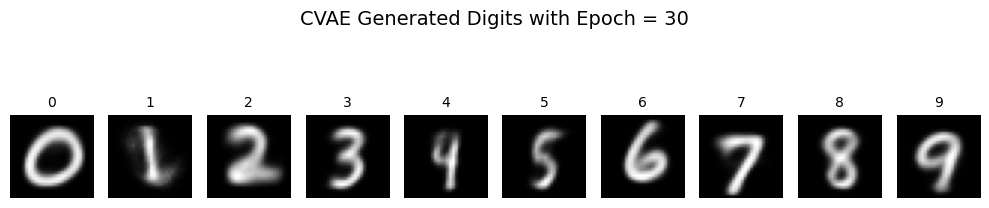

In [21]:
digits = [generate_digits(decoder, digit=i, n=1)[0] for i in range(10)]
plot_digits(digits, title="CVAE Generated Digits with Epoch = 30", filename="task_1e_30epoch_digits.png")

79/79 [==============================] - 0s 1ms/step
Saved to task_1f_30epoch_latent_space.png


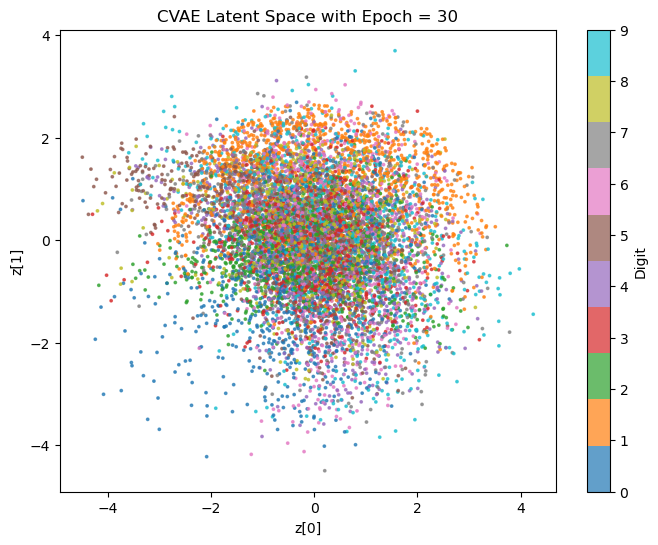

In [22]:
# Assuming you already split or use a subset of test data
plot_latent(encoder, x_train[:10000], y_train[:10000], title="CVAE Latent Space with Epoch = 30", filename="task_1f_30epoch_latent_space.png")


## 🔁 50 Epoch

In [23]:
# Hyperarameters
# --------------

epochs = 50
init_epoch = 30


In [24]:
# !!! TRAIN MODEL - 50 Epoch!!!
# ----------------------------

cvae.fit(train_dataset,
        epochs=epochs,
        initial_epoch=init_epoch,
        batch_size=batch_size,
        shuffle=True)


Epoch 31/50
469/469 [==============================] - 3s 6ms/step - loss: 135.9692 - reconstruction_loss: 132.0193 - kl_loss: 4.3493
Epoch 32/50
469/469 [==============================] - 3s 6ms/step - loss: 135.8139 - reconstruction_loss: 131.8365 - kl_loss: 4.3613
Epoch 33/50
469/469 [==============================] - 3s 6ms/step - loss: 135.6253 - reconstruction_loss: 131.6483 - kl_loss: 4.3707
Epoch 34/50
469/469 [==============================] - 3s 6ms/step - loss: 135.4316 - reconstruction_loss: 131.4796 - kl_loss: 4.3694
Epoch 35/50
469/469 [==============================] - 3s 6ms/step - loss: 135.2825 - reconstruction_loss: 131.3032 - kl_loss: 4.3693
Epoch 36/50
469/469 [==============================] - 3s 6ms/step - loss: 135.0624 - reconstruction_loss: 131.1427 - kl_loss: 4.3816
Epoch 37/50
469/469 [==============================] - 3s 6ms/step - loss: 134.9582 - reconstruction_loss: 130.9954 - kl_loss: 4.3897
Epoch 38/50
469/469 [==============================] - 3s 6ms/

1/1 [==============================] - 0s 14ms/step
Saved to task_1g_50epoch_digits.png


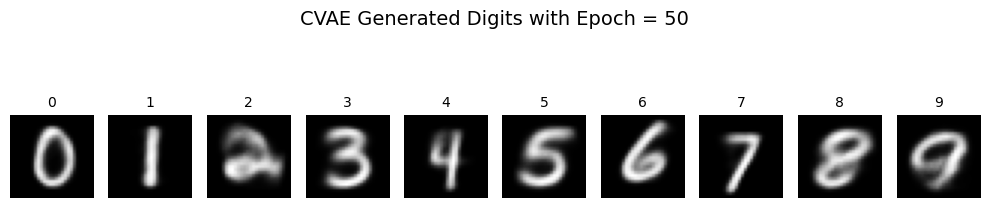

In [25]:
digits = [generate_digits(decoder, digit=i, n=1)[0] for i in range(10)]
plot_digits(digits, title="CVAE Generated Digits with Epoch = 50", filename="task_1g_50epoch_digits.png")

79/79 [==============================] - 0s 1ms/step
Saved to task_1h_50epoch_latent_space.png


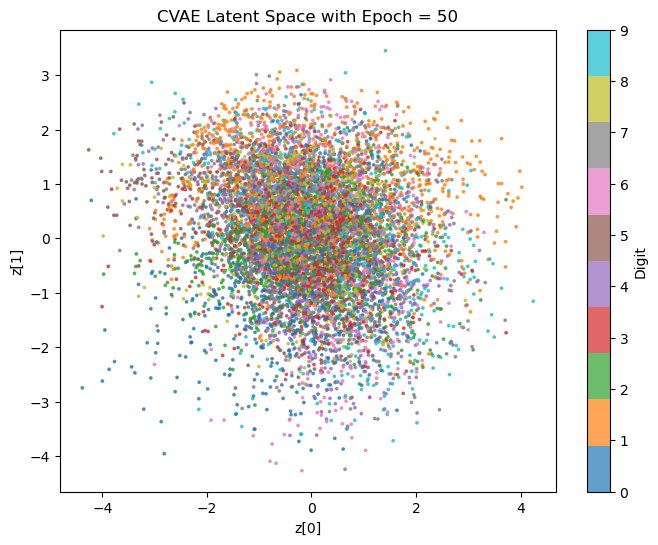

In [26]:
# Assuming you already split or use a subset of test data
plot_latent(encoder, x_train[:10000], y_train[:10000], title="CVAE Latent Space with Epoch = 50", filename="task_1h_50epoch_latent_space.png")


## 🔁 100 Epoch

In [27]:
# Hyperarameters
# --------------

epochs = 100
init_epoch = 50


In [28]:
# !!! TRAIN MODEL - 100 Epoch!!!
# -----------------------------

cvae.fit(train_dataset,
        epochs=epochs,
        initial_epoch=init_epoch,
        batch_size=batch_size,
        shuffle=True)


Epoch 51/100
469/469 [==============================] - 3s 6ms/step - loss: 133.3494 - reconstruction_loss: 129.3478 - kl_loss: 4.4581
Epoch 52/100
469/469 [==============================] - 3s 6ms/step - loss: 133.2856 - reconstruction_loss: 129.2678 - kl_loss: 4.4690
Epoch 53/100
469/469 [==============================] - 3s 6ms/step - loss: 133.2109 - reconstruction_loss: 129.1748 - kl_loss: 4.4686
Epoch 54/100
469/469 [==============================] - 3s 6ms/step - loss: 133.0760 - reconstruction_loss: 129.0917 - kl_loss: 4.4769
Epoch 55/100
469/469 [==============================] - 3s 6ms/step - loss: 133.0619 - reconstruction_loss: 129.0016 - kl_loss: 4.4821
Epoch 56/100
469/469 [==============================] - 3s 6ms/step - loss: 132.8849 - reconstruction_loss: 128.9218 - kl_loss: 4.4817
Epoch 57/100
469/469 [==============================] - 3s 6ms/step - loss: 132.9005 - reconstruction_loss: 128.8369 - kl_loss: 4.4842
Epoch 58/100
469/469 [==============================] -

1/1 [==============================] - 0s 22ms/step
Saved to task_1i_100epoch_digits.png


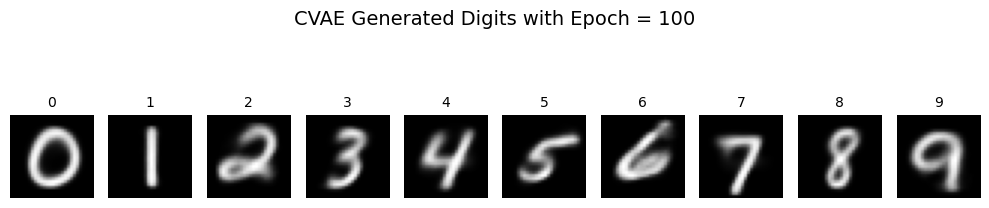

In [29]:
digits = [generate_digits(decoder, digit=i, n=1)[0] for i in range(10)]
plot_digits(digits, title="CVAE Generated Digits with Epoch = 100", filename="task_1i_100epoch_digits.png")

79/79 [==============================] - 0s 1ms/step
Saved to task_1j_100epoch_latent_space.png


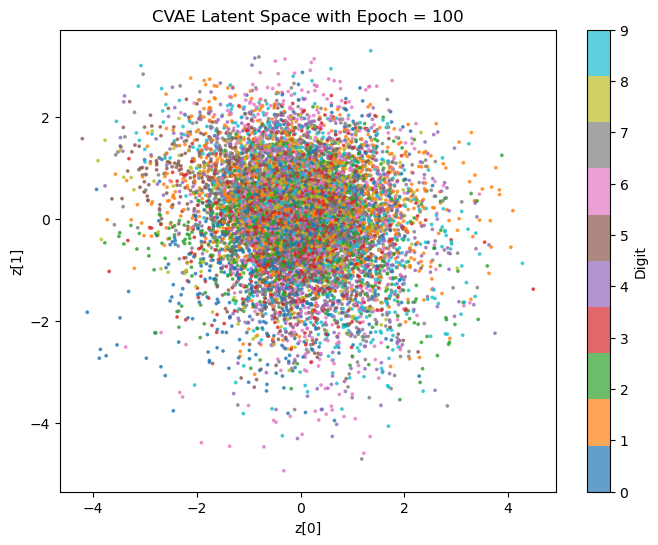

In [30]:
# Assuming you already split or use a subset of test data
plot_latent(encoder, x_train[:10000], y_train[:10000], title="CVAE Latent Space with Epoch = 100", filename="task_1j_100epoch_latent_space.png")


## 🔁 200 Epoch

In [31]:
# Hyperarameters
# --------------

epochs = 200
init_epoch = 100


In [32]:
# !!! TRAIN MODEL - 200 Epoch!!!
# -----------------------------

cvae.fit(train_dataset,
        epochs=epochs,
        initial_epoch=init_epoch,
        batch_size=batch_size,
        shuffle=True)


Epoch 101/200
469/469 [==============================] - 3s 6ms/step - loss: 130.7307 - reconstruction_loss: 126.5556 - kl_loss: 4.6021
Epoch 102/200
469/469 [==============================] - 3s 6ms/step - loss: 130.7073 - reconstruction_loss: 126.5300 - kl_loss: 4.5954
Epoch 103/200
469/469 [==============================] - 3s 6ms/step - loss: 130.5914 - reconstruction_loss: 126.4933 - kl_loss: 4.6041
Epoch 104/200
469/469 [==============================] - 3s 6ms/step - loss: 130.5657 - reconstruction_loss: 126.4547 - kl_loss: 4.5984
Epoch 105/200
469/469 [==============================] - 3s 6ms/step - loss: 130.5311 - reconstruction_loss: 126.4256 - kl_loss: 4.6003
Epoch 106/200
469/469 [==============================] - 3s 6ms/step - loss: 130.4975 - reconstruction_loss: 126.3845 - kl_loss: 4.6084
Epoch 107/200
469/469 [==============================] - 3s 6ms/step - loss: 130.4670 - reconstruction_loss: 126.3578 - kl_loss: 4.6179
Epoch 108/200
469/469 [=========================

1/1 [==============================] - 0s 12ms/step
Saved to task_1k_200epoch_digits.png


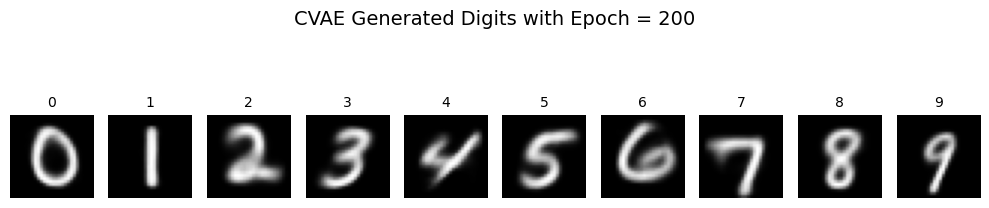

In [33]:
digits = [generate_digits(decoder, digit=i, n=1)[0] for i in range(10)]
plot_digits(digits, title="CVAE Generated Digits with Epoch = 200", filename="task_1k_200epoch_digits.png")

79/79 [==============================] - 0s 1ms/step
Saved to task_1l_200epoch_latent_space.png


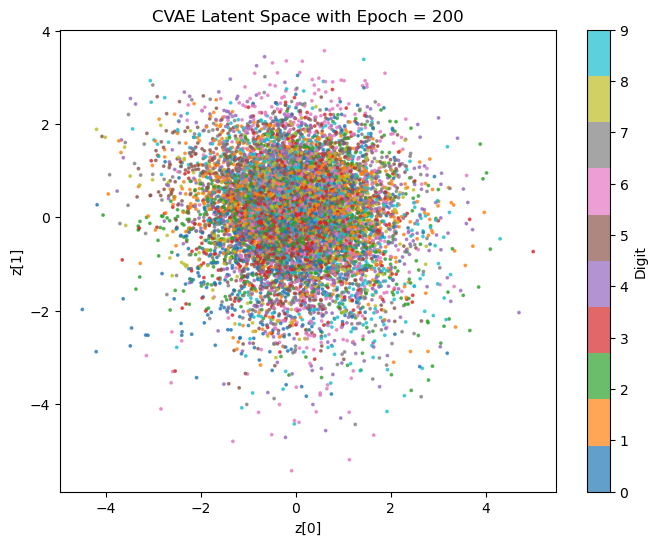

In [34]:
# Assuming you already split or use a subset of test data
plot_latent(encoder, x_train[:10000], y_train[:10000], title="CVAE Latent Space with Epoch = 200", filename="task_1l_200epoch_latent_space.png")


## 📌 Task 3: Analyse the output

- Briefly describe how the latent space has changed with the number of epochs (Approx. 100 words)
- Briefly describe how the quality of generated digits has changed with the number of epochs (Approx. 100 words)
- OPTIONAL - What would happen if you try 50 or 100 epochs? Does the model get better or worse?


### 🧭 Latent Space Evolution

#### Epoch 5

- **Separation is minimal**: Many digit classes overlap significantly in the latent space, indicating that the model hasn’t yet learned well-separated latent representations.
- **Cluster formation is early**: Some clusters begin to form—e.g. digit '1' (orange) shows signs of separating from the dense center.
- **High entropy in distribution**: The latent space distribution is not fully Gaussian and is somewhat elongated along a diagonal suggesting uneven representation learning.
- **Inference**: The CVAE is just beginning to learn how to encode digit-specific features but lacks clear disentanglement.

#### Epoch 15

- **Improved structure**: There is more dispersion and a rough circular latent shape is emerging—closer to a Gaussian prior.
- **Moderate class mixing**: Digits still overlap significantly especially in the center although peripheral clusters (like digits '1' and '0') show mild separation.
- **Latent smoothness increases**: Data points are more evenly spread across the latent dimensions, reducing collapsed regions.
- **Inference**: The latent space is becoming more organized, showing that the encoder-decoder pair is aligning better with the conditional structure of the data.

#### Epoch 30

- **Latent space becomes saturated**: Points are more densely packed near the origin forming a nearly circular cloud but **inter-class separation starts to degrade** slightly compared to Epoch 15.
- **Potential over-regularization**: KL loss may be dominating causing classes to be pulled too closely into the prior distribution.
- **Harder to distinguish digits**: Clustering is less pronounced—likely due to the CVAE focusing more on regularizing the latent space than maintaining class-specific features.
- **Inference**: The encoder might be overfitting to the prior rather than preserving class information, reducing interpretability of the latent space.


### 🖼️ Generated Digits Quality

#### Epoch 5

- **Blurry and inconsistent shapes**: Most digits are poorly formed, with many looking like noisy blobs (especially 2, 5, 6).
- **Low class distinctiveness**: Some digits are almost indistinguishable (e.g. 1, 2) reflecting weak decoder learning.
- **Low fidelity**: The digits lack sharp contours and confidence in strokes.
- **Inference**: The model struggles to decode clear digits due to weak latent representations and insufficient training.

#### Epoch 15

- **Noticeable improvement in clarity**: Digits like 0, 3, 4, 5, 6 and 7 are now recognizable with cleaner lines.
- **Better differentiation**: Most digits have unique features, though some (like 1 and 8) still show shape ambiguity.
- **Smoother edges and strokes**: Pixel quality is higher with less noise and better contrast.
- **Inference**: The decoder has learned to reconstruct core digit shapes well from a moderately structured latent space.

#### Epoch 30

- **High-quality outputs overall**: Most digits are clearly identifiable and more refined in shape.
- **Minor class confusion persists**: Digits like 4 and 9 may still look similar depending on stroke variance.
- **Saturation in improvement**: The visual quality doesn’t drastically improve beyond Epoch 15—some digits are only slightly sharper.
- **Inference**: The model converges in its generation ability, but further gains in quality are diminishing, possibly due to latent compression.


### ⏳ Optional: What if 50 or 100 Epochs?

#### Epoch 50

- **Generated Digits**:
  - **Sharper and more polished**: Many digits are crisp and resemble the MNIST originals quite well.
  - **Visual artifacts in some digits**: For example, 2 and 8 appear overly smooth or slightly distorted suggesting **minor over-smoothing**.
  - **Decoder has stabilized**: The digit reconstructions look consistent across samples, indicating the decoder has reached a **stable convergence point**.
- **Latent Space**:
  - **Class clusters continue to compress**: The space is **densely packed** near the origin, reducing the separation between digit classes.
  - **Reduced interpretability**: Compared to Epoch 15, digits are harder to separate visually in the latent plot—**blurring class boundaries**.
  - **KL divergence is strong**: The KL loss term has likely regularized the latent vectors too aggressively causing **class features to collapse into the prior**.
- **Inference**: While image quality is visually acceptable, the **latent structure deteriorates**, making it harder to use the latent space for downstream tasks like interpolation or clustering.

#### Epoch 100

- **Generated Digits**:
  - **Marginal quality improvement**: Most digits look nearly **perfect** with sharp contours and high contrast.
  - **Diminishing returns**: The difference in quality between Epoch 50 and 100 is **barely noticeable**—mainly slight improvements in pixel uniformity.
  - **Overfitting signs**: Digits like 2 and 6 show **less diversity**, possibly indicating the decoder has **memorized** specific structures rather than learning generalizable ones.
- **Latent Space**:
  - **Highly compressed and uniform**: The latent distribution is even more concentrated in the center with almost **no visible separation** between digit classes.
  - **Prior matching dominates**: The KL loss appears to **override the conditional structure** making all digit labels share nearly the same latent vectors.
  - **Loss of semantic encoding**: The space becomes **less useful for conditional generation**, interpolation, or cluster-based reasoning.
- **Inference**: Although the model produces very clean digits, the loss of **latent expressiveness** suggests that continuing training past 30–50 epochs **does not improve generalization** and may even hurt interpretability.
